# NLP Project: Medical Abstract Sentence Classification

The paper being implemented (PubMed 200k RCT): https://arxiv.org/abs/1710.06071

Model Architecture selected from: https://arxiv.org/abs/1612.05251

<div>
<img src="attachment:NLP_img1.png"/>
</div>

In [ ]:
!nvidia-smi

Wed Jun 28 04:10:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data




In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.36 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Checking files
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Starting the experiment with 20k dataset with numbers replaced with "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Checking all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

In [ ]:
# Function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

The data would be best represented as:
```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': "Emotional eating is associated with overeating and the development of obesity. \n",
  'total_lines': 11},
  ...]
```

In [ ]:
# Preprocessing function

def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""     # an empty abstract
  abstract_samples = []   # an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # reset back to an empty string

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()  # split abstract into separate lines

      # Iterating through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}   # an empty dict for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()  # target text
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
# Getting data from the file\
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 568 ms, sys: 111 ms, total: 678 ms
Wall time: 856 ms


In [ ]:
# Checking first abstract
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Visualizing the data

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distributions of labels in the training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

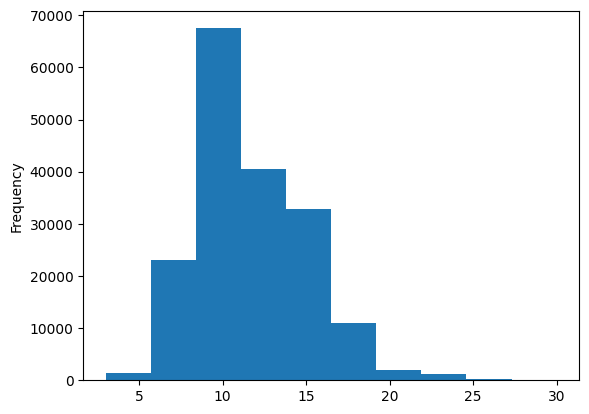

In [ ]:
# Length of different lines
train_df.total_lines.plot.hist()

In [ ]:
# Converting abstract text lines lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Numeric Labels


### One-hot encoding

In [ ]:
# One hot encoding of labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Checking our one-hot encoded vectors
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoding

In [ ]:
# Extracting labels ("target" columns) and their encoding into integers.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a Pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fitting the pipeline
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Downloading helper function script from github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-28 04:10:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-28 04:10:56 (49.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing Data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on avg?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

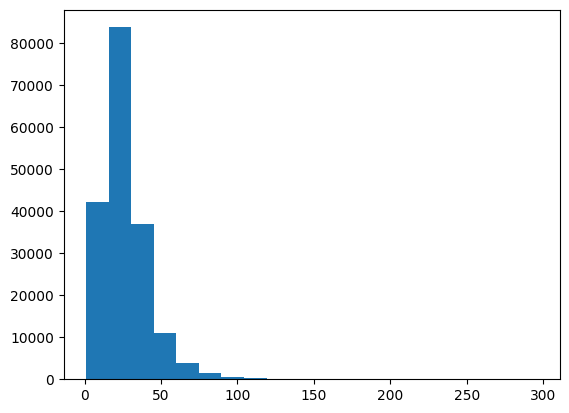

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95 percent of the examples ?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length
max(sent_lens)

296

### Text Vectorizer Layer

In [ ]:
# How many words are there in the Vocab
max_tokens = 68000    # Taken from the paper

In [ ]:
 # Create text vectorizer
 from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

 text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                     output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training examples
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
image quality was better using a nonrigid registration .

Length of text: 9

Vectorized text: [[ 1277   141    10   252    59     8 22380  1330     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Creating custom text-embeddings

In [ ]:
# Creating token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 image quality was better using a nonrigid registration .

Sentence after vectorization (before embedding):
 [[ 1277   141    10   252    59     8 22380  1330     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.04057236  0.00121931 -0.04842559 ...  0.00685174  0.03873925
    0.04618761]
  [ 0.03874191  0.02441952  0.04814919 ...  0.0007726  -0.00269213
   -0.04964172]
  [-0.03175634  0.04282929  0.00157279 ... -0.0317878  -0.02412306
    0.02860321]
  ...
  [ 0.03016832 -0.03214239  0.00528566 ...  0.02846896 -0.00777259
   -0.01894245]
  [ 0.03016832 -0.03214239  0.00528566 ...  0.02846896 -0.00777259
   -0.01894245]
  [ 0.03016832 -0.03214239  0.00528566 ...  0.02846896 -0.00777259
  

## Creating Datasets

In [ ]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compiling the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fitting the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),  #only training on 10 % batches
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 47s 63ms/step - loss: 0.9221 - accuracy: 0.6319 - val_loss: 0.6870 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6613 - accuracy: 0.7519 - val_loss: 0.6342 - val_accuracy: 0.7660
Epoch 3/3
562/562 [==============================] - 6s 9ms/step - loss: 0.6197 - accuracy: 0.7740 - val_loss: 0.5989 - val_accuracy: 0.7812


In [ ]:
# Evaluating on the whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6009 - accuracy: 0.7851


[0.6008642315864563, 0.7850853800773621]

In [ ]:
# Making Prediction
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.28508908e-01, 1.44955248e-01, 9.83686075e-02, 3.02823961e-01,
         2.53431853e-02],
        [4.73985732e-01, 2.58255064e-01, 1.14425169e-02, 2.49801844e-01,
         6.51487662e-03],
        [1.57147065e-01, 1.12042548e-02, 9.71733942e-04, 8.30652714e-01,
         2.42883561e-05],
        ...,
        [4.20880951e-06, 6.39828038e-04, 4.21097560e-04, 2.96406438e-06,
         9.98931944e-01],
        [5.34098111e-02, 3.88501912e-01, 1.44652143e-01, 7.07738325e-02,
         3.42662245e-01],
        [1.26451343e-01, 7.05486119e-01, 2.95765009e-02, 3.39379273e-02,
         1.04548104e-01]], dtype=float32),
 (30212, 5))

In [ ]:
# Converting prediction probas to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculating model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,\
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.50853965311796,
 'precision': 0.7815560522501783,
 'recall': 0.7850853965311797,
 'f1': 0.7827256777790034}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction with Pretrained Token Embeddings

In [ ]:
# Downloading pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 in the single-ventricle patients , controlled reoxygenation cpb significantly ( p < @ ) decreased the markers of organ damage , inflammation , stress , and oxidative stress .
Setence after embedding:
[-0.01964405  0.06482951  0.06637748 -0.01354123  0.04987475  0.03914558
  0.00745433 -0.04351724  0.02310056 -0.00433036  0.08492145 -0.04828316
  0.00527355  0.0729469   0.03035077 -0.07256788 -0.08478342  0.0422708
 -0.02902545 -0.02034211 -0.05750042  0.05716795 -0.00184818 -0.04402683
  0.0388375  -0.06677416 -0.02310297  0.01972634  0.01900949  0.05063865]

Length of sentence embedding: 512


### Building and Fitting an NLP feature and extraction model using pretrained embeddings

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compiling the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 30ms/step - loss: 0.9178 - accuracy: 0.6480 - val_loss: 0.7974 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7695 - accuracy: 0.7023 - val_loss: 0.7535 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7510 - accuracy: 0.7126 - val_loss: 0.7363 - val_accuracy: 0.7158


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 12ms/step - loss: 0.7403 - accuracy: 0.7144


[0.740283191204071, 0.7143518924713135]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[0.4511799 , 0.33985454, 0.00180912, 0.20075873, 0.00639773],
       [0.3328822 , 0.52798784, 0.00215884, 0.1344336 , 0.00253759],
       [0.24725589, 0.14818713, 0.01391045, 0.5514475 , 0.03919904],
       ...,
       [0.00183578, 0.00668842, 0.05053333, 0.00100955, 0.93993294],
       [0.00498895, 0.05255445, 0.20388722, 0.00180443, 0.7367649 ],
       [0.18263327, 0.2406451 , 0.50645167, 0.00793509, 0.06233485]],
      dtype=float32)

In [ ]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 71.43519131470939,
 'precision': 0.7150395866133047,
 'recall': 0.7143519131470939,
 'f1': 0.7116036160850018}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [ ]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n   t h e   s i n g l e - v e n t r i c l e   p a t i e n t s   ,   c o n t r o l l e d   r e o x y g e n a t i o n   c p b   s i g n i f i c a n t l y   (   p   <   @   )   d e c r e a s e d   t h e   m a r k e r s   o f   o r g a n   d a m a g e   ,   i n f l a m m a t i o n   ,   s t r e s s   ,   a n d   o x i d a t i v e   s t r e s s   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

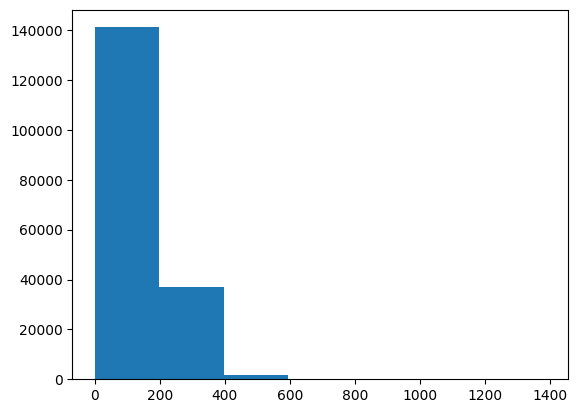

In [ ]:
# Checking the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# What character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Getting all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Checking character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Testing out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 a n d r o g e n   d e p r i v a t i o n   (   a d t   )   i s   a s s o c i a t e d   w i t h   m u s c l e   l o s s   a n d   i n c r e a s e d   b o d y   f a t   ,   a n d   c u r r e n t l y   a v a i l a b l e   t h e r a p i e s   h a v e   l i m i t e d   e f f i c a c y   t o   t r e a t   t h i s   c o m p l i c a t i o n   .

Length of random_train_chars: 143

Vectorized chars:
 [[ 5  6 10  8  7 18  2  6 10  2 14  8  4 21  5  3  4  7  6  5 10  3  4  9
   5  9  9  7 11  4  5  3  2 10 20  4  3 13 15 16  9 11 12  2 12  7  9  9
   5  6 10  4  6 11  8  2  5  9  2 10 22  7 10 19 17  5  3  5  6 10 11 16
   8  8  2  6  3 12 19  5 21  5  4 12  5 22 12  2  3 13  2  8  5 14  4  2
   9 13  5 21  2 12  4 15  4  3  2 10  2 17 17  4 11  5 11 19  3  7  3  8
   2  5  3  3 13  4  9 11  7 15 14 12  4 11  5  3  4  7  6  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a character level embedding

In [ ]:
# char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 a n d r o g e n   d e p r i v a t i o n   (   a d t   )   i s   a s s o c i a t e d   w i t h   m u s c l e   l o s s   a n d   i n c r e a s e d   b o d y   f a t   ,   a n d   c u r r e n t l y   a v a i l a b l e   t h e r a p i e s   h a v e   l i m i t e d   e f f i c a c y   t o   t r e a t   t h i s   c o m p l i c a t i o n   .

Embedded chars (after vectorization and embedding):
 [[[ 0.04232887 -0.01391479 -0.02050957 ...  0.03693271 -0.01902816
    0.00369129]
  [-0.02091858 -0.00828377  0.01678394 ...  0.01745129  0.01983739
   -0.01327538]
  [ 0.03547932 -0.01356622 -0.01906917 ... -0.03475899  0.0447378
    0.00797379]
  ...
  [-0.00757568 -0.01354033  0.0344904  ...  0.00290457 -0.00052372
    0.00228752]
  [-0.00757568 -0.01354033  0.0344904  ...  0.00290457 -0.00052372
    0.00228752]
  [-0.00757568 -0.01354033  0.0344904  ...  0.00290457 -0.00052372
    0.00228752]]]

Character embedding shape: (1, 290, 25)


In [ ]:
# token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Concatenating token and char inputs (hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
# Creating output layers (with Dropout)
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Constructing model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# Getting a summary of model 4
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

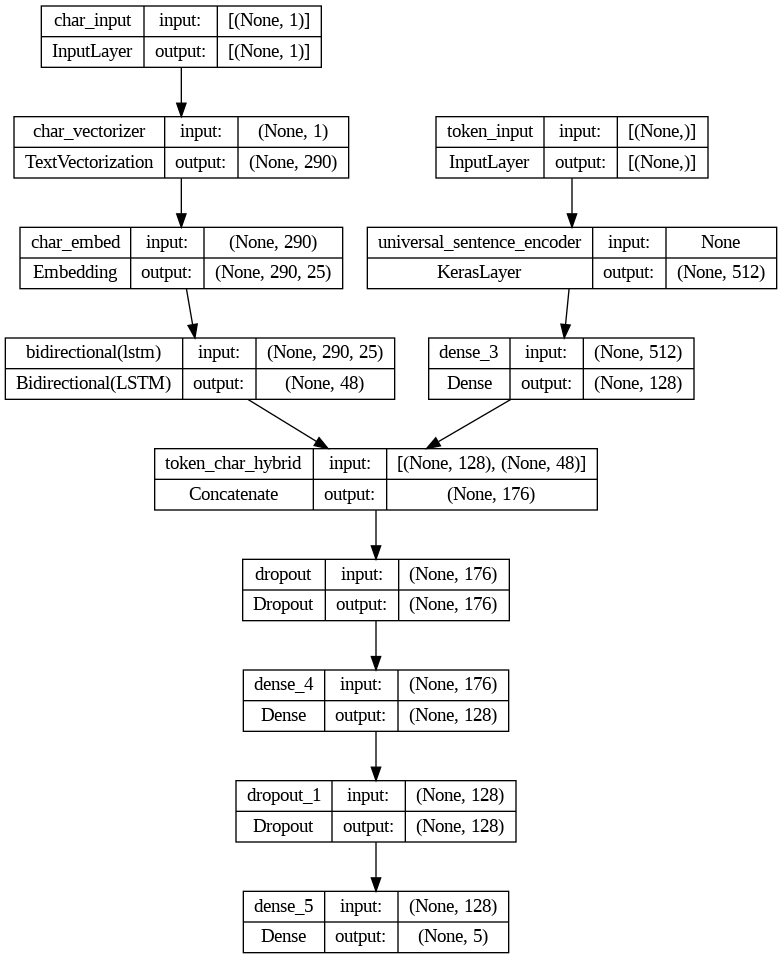

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy"])

### Combining token and character data into tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeating the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 54s 71ms/step - loss: 0.9880 - accuracy: 0.6043 - val_loss: 0.7949 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.8074 - accuracy: 0.6906 - val_loss: 0.7269 - val_accuracy: 0.7237
Epoch 3/3
562/562 [==============================] - 38s 68ms/step - loss: 0.7749 - accuracy: 0.7061 - val_loss: 0.7040 - val_accuracy: 0.7311


In [ ]:
# Evaluating on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.7085 - accuracy: 0.7291


[0.7085348963737488, 0.7290811538696289]

In [ ]:
# Making predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 22ms/step


array([[4.1695940e-01, 4.1564015e-01, 3.4670851e-03, 1.5709299e-01,
        6.8403217e-03],
       [3.6926800e-01, 4.6748194e-01, 3.7129812e-03, 1.5735838e-01,
        2.1787914e-03],
       [2.1977158e-01, 8.8029914e-02, 1.7725827e-02, 6.6243356e-01,
        1.2039072e-02],
       ...,
       [6.4228527e-04, 5.8529261e-03, 4.8504092e-02, 3.6426808e-04,
        9.4463646e-01],
       [9.6713565e-03, 9.9941440e-02, 1.9907232e-01, 4.6550147e-03,
        6.8665987e-01],
       [3.1451944e-01, 2.6574564e-01, 3.3176437e-01, 2.3327712e-02,
        6.4642824e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 72.90811598040514,
 'precision': 0.7325576799808695,
 'recall': 0.7290811598040514,
 'f1': 0.7273520441054511}

# Recurrent Neural Network

<ins>**Premise**</ins>: Use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

* When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

**Example**:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

<div>
    <div align="left">
        <img src="attachment:RNN.png" align="left" width="500"/>
    </div>
</div>

* $ s_{i} = \sigma{(Ux_{i} + Ws_{i-1} + b)} $
* $ y_{i} = \mathcal{O}(Vs_{i} + c) $

  where $s_{i}$ is state of the network and $y_{i}$ is the output of the network, at timestep i.
  
* The parameters are W, U, V, c, b which are shared across timesteps, and hence the same network can be used to compute $y_{1}, y_{2}, \dots, y_{10}$ or $y_{100}$

## Backpropagation through Time

<div>
    <div align="left">
        <img src="attachment:Btt_img.png" align="left" width="500"/>
    </div>
</div>

* Suppose that there are only 4 characters in the vocabulary (d, e, p, $<stop>$)
* At each timestep we want our model to predict one of these 4 characters.

<div>
    <div align="left">
        <img src="attachment:Btt_img2.png" align="left" width="500"/>
    </div>
</div>

  
* Suppose we initialize U, V, W randomly and the network predicts the probabilities as shown
* We need to answer two question:
    1. What is the total loss made by the model?
    2. How do we backpropagate this loss and update the parameters (θ = {U, V, W, b, c}) of the network ?

* The total loss is simply the sum of the loss over all time steps

$$ \mathcal{L}(\theta) = \Sigma_{t=1}^{T} \mathcal{L}_{t}(\theta)$$

$$ \mathcal{L}(\theta) =  -\log(y_{tc})$$

where $y_{tc} =$ predicted probabilty of true character at timestep t and T is the total number of timesteps.

* For backpropagation, we need to compute the gradients w.r.t. W, U, V, b, c

<div>
    <div align="left">
        <img src="attachment:Btt_img3.png" align="left" width="500"/>
    </div>
</div>

 $\frac{\partial \mathcal{L}(\theta)}{\partial V} = \Sigma_{t=1}^{T} \frac{\partial \mathcal{L}_{t}(\theta)}{\partial V}$

* Let us consider the derivative $\frac{\partial \mathcal{L}(\theta)}{\partial W}$
$$ \frac{\partial \mathcal{L}(\theta)}{\partial V} = \Sigma_{t=1}^{T} \frac{\partial \mathcal{L}_{t}(\theta)}{\partial W} $$

* By the chain rule of derivative we know that $\frac{\partial \mathcal{L}_{t}(\theta)}{\partial W}$ is obtained by summing gradients along all the paths from $\mathcal{L}_{t}(\theta)$ to W.

<div>
    <div align="left">
        <img src="attachment:Btt_img4.png" align="left" width="500"/>
    </div>
</div>

* $\mathcal{L}_{4}(\theta)$ depends on $s_{4}$
* $s_{4}$ in turn depends on $s_{3} and W$
* $s_{3}$ in turn depends on $s_{2} and W$
* $s_{2}$ in turn depends on $s_{1} and W$
* $s_{1}$ in turn depends on $s_{0} and W$

where $s_0$ is a constant starting state.

<div>
    <div align="left">
        <img src="attachment:Btt_img4.png" align="left" width="500"/>
    </div>
</div>

* Now we have
    $$ \frac{\partial \mathcal{L}_{4}(\theta)}{\partial W} = \frac{\partial \mathcal{L}_{4}(\theta)}{\partial s_{4}} \frac{\partial s_{4}}{\partial W} $$


* $ \frac{\partial \mathcal{L}_{4}(\theta)}{\partial s_{4}}$ can be combuted easily.

* But how do we compute $\frac{\partial s_{4}}{\partial W}$ ?

<div>
    <div align="left">
        <img src="attachment:Btt_img4.png" align="left" width="500"/>
    </div>
</div>

* Since
    $$ s_{4} = \sigma(Ws_{3} + b)$$
  we can't compute $\frac{\partial s_{4}}{\partial W}$ by simply treating $s_{3}$ as a constant (because it also depends on W)
  
* In such networks the total derivative, $\frac{\partial s_{4}}{\partial W}$ has two parts:
    1. **Explicit:** $\frac{\partial^{+} s_{4}}{\partial W}$, treating all other inputs as constant.
    2. **Implicit:** Summing over all indirect paths from $s_4$ to W

<div>
    <div align="left">
        <img src="attachment:Btt_img4.png" align="left" width="500"/>
    </div>
</div>

* Finally, we have
    $$ \frac{\partial \mathcal{L}_{4}(\theta)}{\partial W} = \frac{\partial \mathcal{L}_{4}(\theta)}{\partial s_{4}} \frac{\partial s_{4}}{\partial W} $$
    
    where $\frac{\partial s_{4}}{\partial W} = \Sigma_{k=1}^{4}\frac{\partial s_{4}}{\partial s_{k}} \frac{\partial^{+} s_{k}}{\partial W}$
    
    $\therefore \frac{\partial \mathcal{L}_{t}(\theta)}{\partial W} = \frac{\partial \mathcal{L}_{t}(\theta)}{\partial s_{t}} \Sigma_{k=1}^{t}\frac{\partial s_{t}}{\partial s_{k}} \frac{\partial^{+} s_{k}}{\partial W}$
    
* This algorithm is called backpropagation through time (BPTT) as we back propagate through all previous time steps.

# Modelling

### Creating Positional Embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<Axes: ylabel='Frequency'>

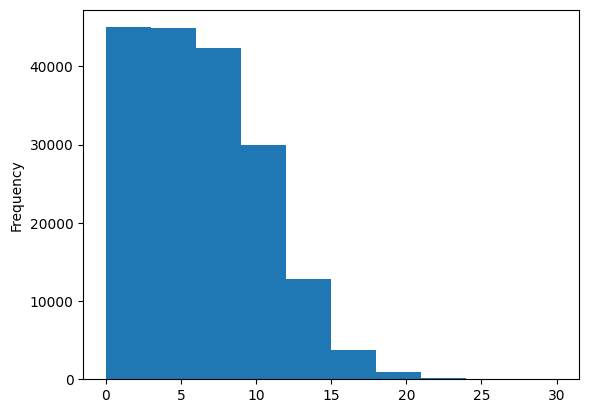

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

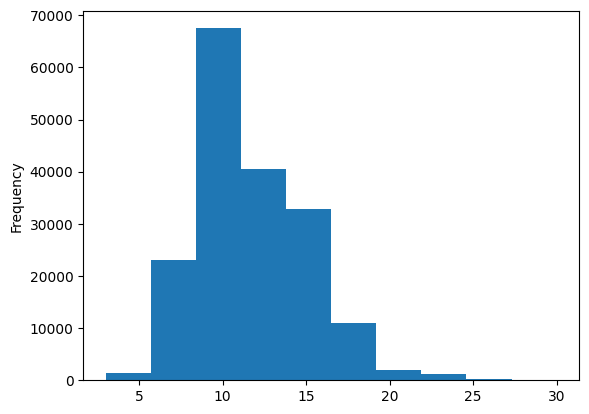

In [ ]:
# Checking the distributions of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Checking the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Using TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [ ]:
# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

In [ ]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

In [ ]:
# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

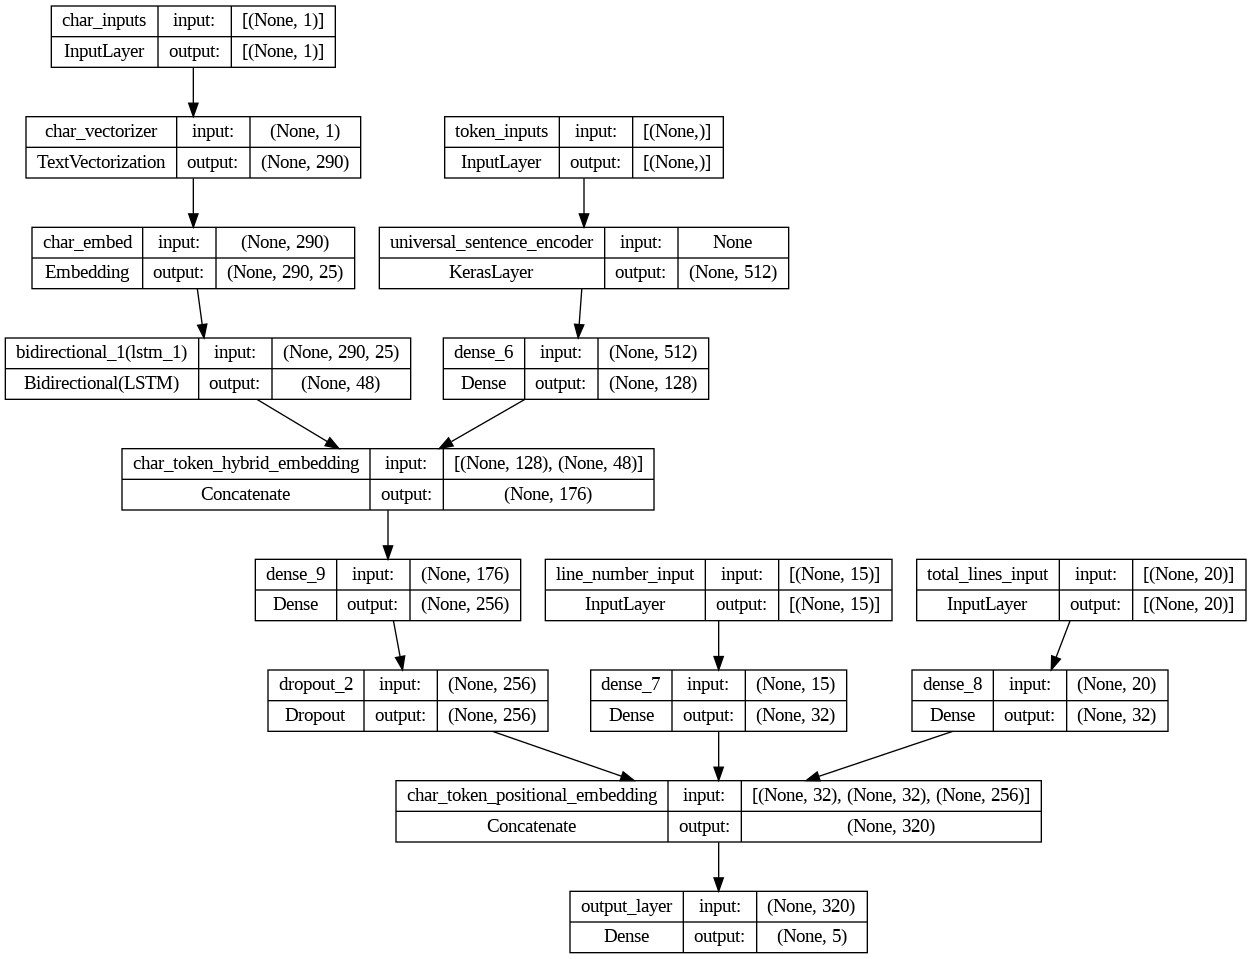

In [ ]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Creating training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Doing the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 57ms/step - loss: 1.0906 - accuracy: 0.7296 - val_loss: 0.9833 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 31s 55ms/step - loss: 0.9676 - accuracy: 0.8162 - val_loss: 0.9485 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9504 - accuracy: 0.8231 - val_loss: 0.9398 - val_accuracy: 0.8348


In [ ]:
# Making predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 26s 23ms/step


array([[0.46907705, 0.11536922, 0.01038145, 0.3896173 , 0.01555498],
       [0.53334725, 0.10537725, 0.04094024, 0.30972168, 0.01061351],
       [0.26760906, 0.11699015, 0.11541004, 0.43263927, 0.06735139],
       ...,
       [0.03139   , 0.09141108, 0.04851005, 0.03102653, 0.7976623 ],
       [0.03041771, 0.2617843 , 0.07781088, 0.02795838, 0.6020287 ],
       [0.19538003, 0.62005794, 0.09746271, 0.03379044, 0.05330882]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.30464716006884,
 'precision': 0.8321449511648427,
 'recall': 0.8330464716006885,
 'f1': 0.8324632660075258}

In [ ]:
model_5.save("/content/drive/MyDrive/skimlit_tribrid_model")